In [1]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

In [2]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_va, y_train, y_va = train_test_split(X_1, y_1)

print(X_train.shape, y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2025, 54) (2025,)
[1 2 3 4 5 6 7]


In [3]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_va_enc = enc.fit_transform(y_va.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)


In [4]:
# label.shape = (num_sample, )
train_dataset = lgb.Dataset(data=X_train, label=y_train_enc.reshape(-1, ))
val_dataset = lgb.Dataset(data=X_va, label=y_va_enc.reshape(-1, ))

In [5]:
from sklearn.metrics import log_loss


def my_gbm_loss(y_pred, y_true):
    print(y_true.get_label())
    """lightgbm自定义验证数据集损失函数格式"""
    # 多分类任务中,y_pred先按类进行分组(比如前7个值是y_true[0]的预测值,最后7个值是y_true[-1]的预测值)
    reshape_y_pred = np.transpose(y_pred.reshape(7, -1))  # 这是一个7分类任务
    loss = log_loss(y_true.get_label(), reshape_y_pred)
    # y_true.get_label().shape=(2025, )
    # y_pred.shape=(2025 *7, )
    # reshape_y_pred.shape=(2025, 7)
    # print("y_true.shape:{0},y_pred.shape:{1},reshape_y_pred.shape:{2}".format(y_true.get_label().shape, y_pred.shape, reshape_y_pred.shape))
    # 返回值格式:评估函数的名称(不含空格), 评估结果, 评估结果是否越高越高(比如AUC是越高越好,损失值是越低越好)
    return 'MY_GBM_LOSS', loss, False

In [6]:
evals_result = {}  # 储存评估指标(内置和自定义)结果
re_func = lgb.record_evaluation(eval_result=evals_result)
es_func = lgb.early_stopping(stopping_rounds=200)
le_func = lgb.log_evaluation(100)

params = {"objective": "multiclass",
          "num_class": 7,
          "verbose": -4, "metric": ("multi_logloss",)}

eval_set = [train_dataset, val_dataset]

model = lgb.train(params=params,
                  train_set=train_dataset,
                  # List of data to be evaluated on during training.
                  valid_sets=eval_set,
                  callbacks=[re_func, es_func, le_func],
                  num_boost_round=200,  # 默认num_boost_round=1000
                  feval=my_gbm_loss)  # Customized evaluation function

# 预测结果为概率向量(多分类)
# X_test: numpy array, pandas DataFrame
model.predict(X_test)

[4. 4. 4. ... 5. 4. 5.]
[2. 1. 1. 4. 1. 1. 4. 1. 1. 6. 4. 1. 1. 1. 1. 4. 5. 0. 0. 1. 1. 4. 1. 4.
 1. 0. 4. 0. 4. 0. 1. 4. 0. 1. 0. 4. 4. 4. 0. 4. 1. 1. 5. 1. 1. 4. 0. 4.
 1. 3. 4. 4. 1. 1. 2. 1. 1. 0. 0. 1. 2. 1. 2. 0. 0. 0. 1. 2. 5. 6. 5. 1.
 1. 4. 1. 5. 1. 1. 5. 4. 1. 1. 1. 6. 4. 0. 3. 3. 1. 4. 2. 5. 4. 1. 4. 5.
 2. 4. 5. 0. 0. 1. 1. 2. 6. 2. 1. 5. 5. 4. 4. 0. 4. 4. 1. 4. 2. 0. 2. 1.
 0. 4. 1. 0. 4. 3. 5. 4. 6. 1. 3. 0. 0. 5. 3. 0. 4. 0. 0. 1. 1. 1. 1. 2.
 0. 0. 1. 1. 0. 1. 0. 1. 0. 4. 1. 0. 2. 4. 4. 3. 4. 1. 1. 4. 2. 4. 0. 1.
 0. 4. 4. 5. 4. 2. 1. 4. 4. 1. 4. 4. 0. 4. 4. 2. 0. 6. 1. 0. 1. 5. 2. 4.
 1. 5. 4. 4. 1. 5. 4. 0. 4. 4. 0. 0. 4. 1. 4. 2. 5. 0. 1. 1. 4. 1. 4. 1.
 4. 3. 5. 5. 1. 4. 0. 1. 3. 4. 1. 5. 4. 4. 2. 0. 4. 4. 4. 6. 0. 2. 0. 4.
 4. 2. 0. 1. 5. 4. 5. 4. 4. 1. 1. 6. 4. 1. 4. 0. 1. 3. 1. 5. 2. 4. 1. 4.
 4. 0. 1. 4. 2. 3. 1. 1. 0. 1. 1. 0. 6. 4. 6. 0. 6. 1. 1. 4. 1. 1. 0. 4.
 4. 1. 0. 1. 1. 1. 0. 4. 4. 4. 1. 4. 0. 3. 1. 4. 4. 1. 4. 1. 0. 4. 3. 0.
 3. 2. 1. 2. 1. 5. 1. 4. 4.

array([[1.14409739e-07, 8.53681420e-07, 2.38197131e-10, ...,
        3.36247982e-08, 9.99998998e-01, 3.38638165e-10],
       [2.68264333e-05, 1.90437454e-05, 8.60217414e-08, ...,
        9.62566967e-01, 3.73869353e-02, 6.29961805e-08],
       [4.27554250e-01, 5.72438896e-01, 8.88900916e-07, ...,
        3.27967565e-06, 9.96399609e-07, 2.63126136e-07],
       ...,
       [5.93284076e-03, 9.93936488e-01, 1.29679425e-06, ...,
        9.05279191e-05, 2.81978158e-05, 9.01238807e-06],
       [4.44611952e-10, 2.65774185e-05, 7.42844900e-10, ...,
        9.99973421e-01, 6.38656300e-11, 1.58728810e-10],
       [4.39876816e-04, 9.99505239e-01, 1.84893666e-06, ...,
        1.05592028e-06, 5.17585541e-05, 8.17319853e-08]])

In [7]:
# The best score of fitted model.
model.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('multi_logloss', 8.002446375281727e-05),
                          ('MY_GBM_LOSS', 8.002446375281332e-05)]),
             'valid_1': OrderedDict([('multi_logloss', 0.7998165556112901),
                          ('MY_GBM_LOSS', 0.7998165556112901)])})

In [8]:
evals_result

{'training': OrderedDict([('multi_logloss',
               [1.3665963308736961,
                1.1689089609695564,
                1.0216357062901908,
                0.905246174485473,
                0.8076538228153117,
                0.7272052033475445,
                0.6598098980956524,
                0.5975128050784839,
                0.5454419669787346,
                0.5004487397528503,
                0.4608370771154692,
                0.4247673512955527,
                0.3927906045283665,
                0.36357455385038157,
                0.3373487499397249,
                0.31218477405670514,
                0.28994296113738394,
                0.27035031282636834,
                0.25192834355869476,
                0.23492652833287545,
                0.22053355278031608,
                0.20602698759951585,
                0.19338953135775608,
                0.18109454863751345,
                0.1704459113563112,
                0.16065098737027414,
          

In [9]:
evals_result['training'].keys()

odict_keys(['multi_logloss', 'MY_GBM_LOSS'])

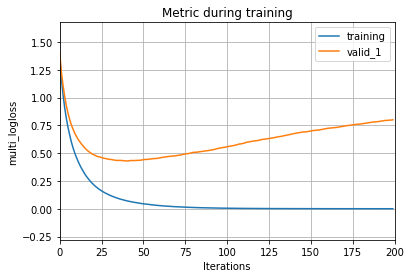

In [10]:
# Plot one metric during training.
ax = lgb.plot_metric(evals_result, metric='multi_logloss')  # multi_logloss指标绘制
plt.show()

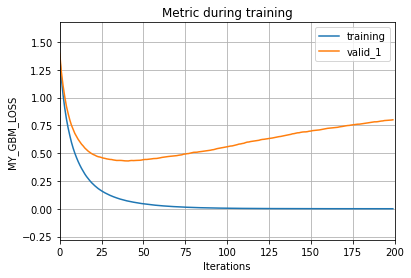

In [11]:
ax1 = lgb.plot_metric(evals_result, metric="MY_GBM_LOSS")  # MY_GBM_LOSS指标绘制
plt.show()

In [12]:
# 特征的相对重要性
model.feature_importance()

array([5518, 2411, 1459, 2828, 2706, 4990, 2302, 2374, 2187, 5016,  282,
          0,  165,   61,  179,   34,    0,    0,   46,    0,    0,    0,
          0,  113,    0,  146,   91,    0,    0,    0,   47,   41,    0,
        250,    0,   44,  117,   27,    0,    0,    0,    0,  279,  266,
          1,   49,   62,    0,    0,    0,    0,   67,   11,    0])

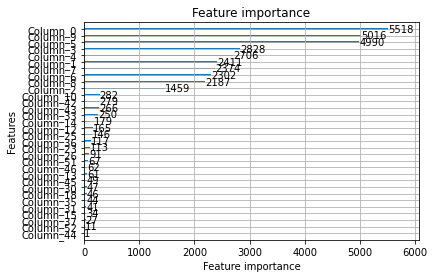

In [13]:
# 绘制特征的相对重要性
lgb.plot_importance(model)
plt.show()

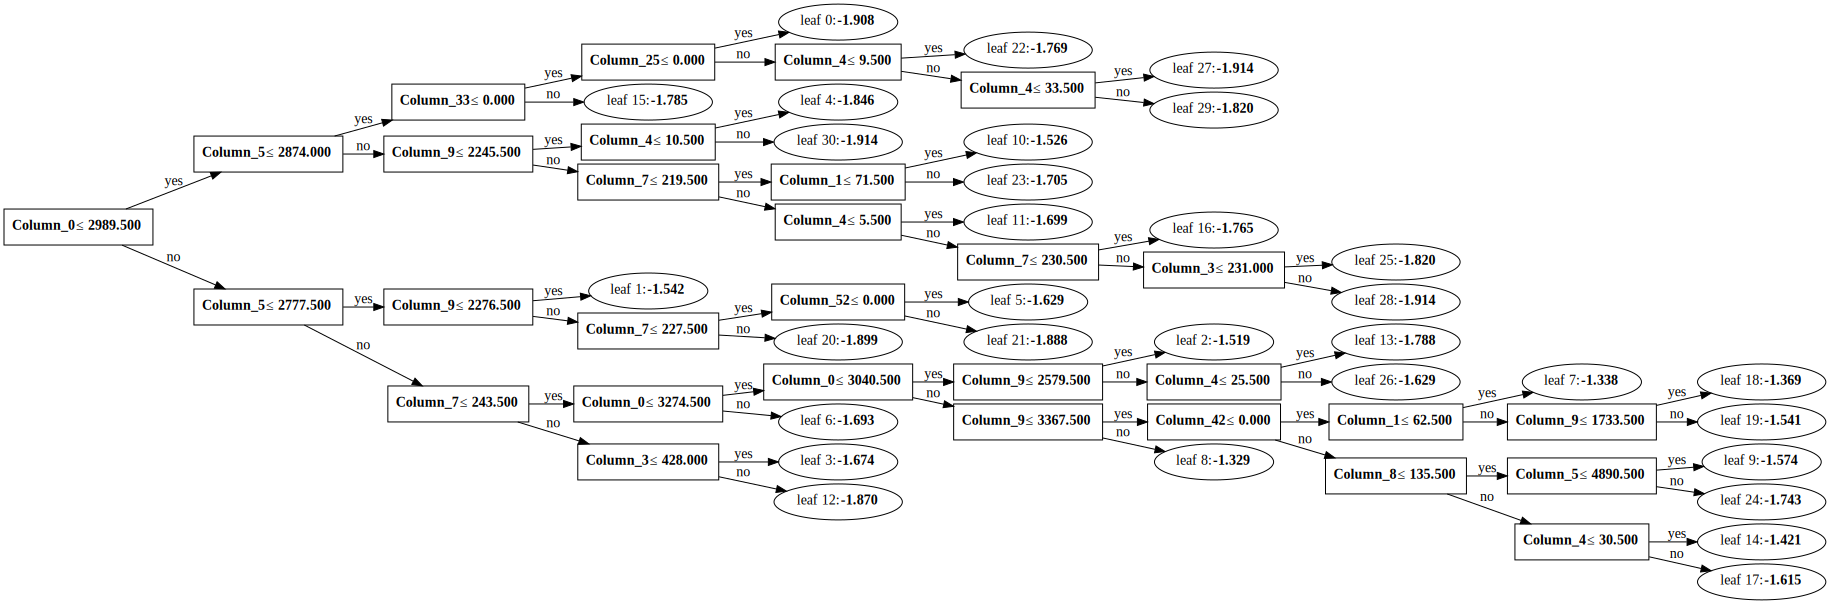

In [14]:
# 可视化lgb分割过程
img = lgb.create_tree_digraph(model)
img

In [15]:
# 数据类型为graphviz.dot.Digraph
type(img)

graphviz.graphs.Digraph

In [16]:
# 图保存
# 可对img_view.gv中的数据进行解析
img.view(filename="img_view.gv")

'img_view.gv.pdf'